<a href="https://colab.research.google.com/github/reiinakano/neural-painters/blob/master/notebooks/recreating_spiral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optionally connect to Google Drive

# Install MyPaint and other dependencies

In [1]:
# !pip install future-fstrings

In [2]:
# !git clone https://github.com/reiinakano/SPIRAL-tensorflow.git
# !cd SPIRAL-tensorflow && git checkout reiinakano-patch-2  #reiinakano-patches
# !cd SPIRAL-tensorflow && git pull

In [3]:
# ! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# ! unzip ngrok-stable-linux-amd64.zip

# Download the CelebA dataset

We download the CelebA dataset from Kaggle. You will need to set your Kaggle API credentials via https://github.com/Kaggle/kaggle-api#api-credentials

In [4]:
# !pip install kaggle

In [5]:
# !mkdir -p ~/.kaggle

# Make sure to upload your Kaggle key from somewhere. I saved mine in Drive
#!cp "/drive/My Drive/kaggle.json" ~/.kaggle/

In [6]:
# !kaggle datasets download -d jessicali9530/celeba-dataset -f img_align_celeba.zip 
# !unzip -q img_align_celeba.zip

# Download pre-trained VAE and GAN Neural Painters

I have prepared pre-trained VAE and GAN Neural Painters here but feel free to use your own if you wish.

Place the VAE in tf_vae and the GAN in tf_gan3

In [7]:
# !mkdir tf_vae
# !wget -O tf_vae/vae-300000.index 'https://docs.google.com/uc?export=download&id=1ulHdDxebH46m_0ZoLa2Wsz_6vStYqJQm'
# !wget -O tf_vae/vae-300000.meta 'https://docs.google.com/uc?export=download&id=1nHN_i7Ro9g0lP4y_YQCvIWrOVX1I3CJa'
# !wget -O tf_vae/vae-300000.data-00000-of-00001 'https://docs.google.com/uc?export=download&id=18rAJcUJwFJOAcjzsabtqK12udsHMZkVk'
# !wget -O tf_vae/checkpoint 'https://docs.google.com/uc?export=download&id=18U4qMNBdyvEk-Y-Mr3MNPEHSHxhcO9hn'

# !mkdir tf_gan3
# !wget -O tf_gan3/gan-571445.meta 'https://docs.google.com/uc?export=download&id=15kEG1Tiu2FUg5SILVt_9yOsSd3QHwVGA'
# !wget -O tf_gan3/gan-571445.index 'https://docs.google.com/uc?export=download&id=11uyFbQsRZoWa9Yq52AFXDXPjPQoGF_ER'
# !wget -O tf_gan3/gan-571445.data-00000-of-00001 'https://docs.google.com/uc?export=download&id=11cbvz-CH3KvfZEwNQ2OUujfbf6AKNoQa'
# !wget -O tf_gan3/checkpoint 'https://docs.google.com/uc?export=download&id=1A539u51t0L31Ab1M2uPUV2SsCFsNDQRo'


# Imports

If you encounter `SyntaxError: encoding problem: future_fstrings` then please "Restart Runtime" (NOT "Reset all Runtimes") and start from this point. I think this is because we are installing a library "future-fstrings" but it won't get loaded in until the runtime is reset :( If someone knows a fix please let me know.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

import tensorflow as tf
import os
import random
import time
from collections import namedtuple


import sys
# sys.path.append('mypaint')
sys.path.append('..')

from tqdm import tqdm
import tensorflow as tf
from PIL import Image, ImageDraw
from collections import defaultdict

# from lib import surface, tiledsurface, brush
import utils as ut
# from envs.mypaint_utils import *

import moviepy.editor as mpy
from IPython.display import display

import tensorflow.contrib.layers as tcl

import imageio


print(tf.__version__)

/home/dl/anaconda3/envs/paint/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dl/anaconda3/envs/paint/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dl/anaconda3/envs/paint/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dl/anaconda3/envs/paint/lib/python3.7/site-packages/ten

1.13.1


In [9]:
imageio.plugins.freeimage.download()

In [10]:
# class args:
#   jump=True
#   curve=True
#   screen_size=64
#   location_size=32
#   color_channel=3
#   brush_path='SPIRAL-tensorflow/assets/brushes/dry_brush.myb'
#   train=True
#   data_dir=Path('data')

# paint environment

In [11]:
# class PaintMode:
#   STROKES_ONLY = 0
#   JUMP_STROKES = 1
#   CONNECTED_STROKES = 2

# class ColorEnv():
#     head = 0.25
#     tail = 0.75
    
#     # all 0 to 1
#     actions_to_idx = {
#         'pressure': 0,
#         'size': 1,
#         'control_x': 2,
#         'control_y': 3,
#         'end_x': 4,
#         'end_y': 5,
#         'color_r': 6,
#         'color_g': 7,
#         'color_b': 8,
#         'start_x': 9,
#         'start_y': 10,
#         'entry_pressure': 11,
#     }

#     def __init__(self, args, paint_mode=PaintMode.JUMP_STROKES):
#         self.args = args
#         self.paint_mode = paint_mode

#         # screen
#         self.screen_size = args.screen_size
#         self.height, self.width = self.screen_size, self.screen_size
#         self.observation_shape = [
#                 self.height, self.width, args.color_channel]

#         # location
#         self.location_size = args.location_size
#         self.location_shape = [self.location_size, self.location_size]
        
#         self.prev_x, self.prev_y, self.prev_pressure = None, None, None
    
#     @staticmethod
#     def pretty_print_action(ac):
#         for k, v in ColorEnv.actions_to_idx.items():
#             print(k, ac[v])
    
#     def random_action(self):
#         return np.random.uniform(size=[len(self.actions_to_idx)])
      
#     def reset(self):
#         self.intermediate_images = []
#         self.prev_x, self.prev_y, self.prev_pressure = None, None, None

#         self.s = tiledsurface.Surface()
#         self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
#         self.s.begin_atomic()

#         with open(self.args.brush_path) as fp:
#             self.bi = brush.BrushInfo(fp.read())
#         self.b = brush.Brush(self.bi)

#     def draw(self, ac, s=None, dtime=1):
#         # Just added this
#         if self.paint_mode == PaintMode.STROKES_ONLY:
#           self.s.clear()
#           self.s.flood_fill(0, 0, (255, 255, 255), (0, 0, 64, 64), 0, self.s)
#           self.s.end_atomic()
#           self.s.begin_atomic()
        
#         if s is None:
#             s = self.s

#         s_x, s_y = ac[self.actions_to_idx['start_x']]*64, ac[self.actions_to_idx['start_y']]*64  
#         e_x, e_y = ac[self.actions_to_idx['end_x']]*64, ac[self.actions_to_idx['end_y']]*64
#         c_x, c_y = ac[self.actions_to_idx['control_x']]*64, ac[self.actions_to_idx['control_y']]*64
#         color = (
#             ac[self.actions_to_idx['color_r']],
#             ac[self.actions_to_idx['color_g']],
#             ac[self.actions_to_idx['color_b']],
#         )
#         pressure = ac[self.actions_to_idx['pressure']]*0.8
#         entry_pressure = ac[self.actions_to_idx['entry_pressure']]*0.8
#         size = ac[self.actions_to_idx['size']] * 2.
        
#         if self.paint_mode == PaintMode.CONNECTED_STROKES:
#             if self.prev_x is not None:
#                 s_x, s_y, entry_pressure = self.prev_x, self.prev_y, self.prev_pressure
#             self.prev_x, self.prev_y, self.prev_pressure = e_x, e_y, pressure

#         self.b.brushinfo.set_color_rgb(color)
        
#         self.b.brushinfo.set_base_value('radius_logarithmic', size)

#         # Move brush to starting point without leaving it on the canvas.
#         self._stroke_to(s_x, s_y, 0)

#         self._draw(s_x, s_y, e_x, e_y, c_x, c_y, entry_pressure, pressure, size, color, dtime)

#     def _draw(self, s_x, s_y, e_x, e_y, c_x, c_y,
#               entry_pressure, pressure, size, color, dtime):

#         # if straight line or jump
#         if pressure == 0:
#             self.b.stroke_to(
#                     self.s.backend, e_x, e_y, pressure, 0, 0, dtime)
#         else:
#             self.curve(c_x, c_y, s_x, s_y, e_x, e_y, entry_pressure, pressure)
            
#         # Relieve brush pressure for next jump
#         self._stroke_to(e_x, e_y, 0)

#         self.s.end_atomic()
#         self.s.begin_atomic()

#     # sx, sy = starting point
#     # ex, ey = end point
#     # kx, ky = curve point from last line
#     # lx, ly = last point from InteractionMode update
#     def curve(self, cx, cy, sx, sy, ex, ey, entry_pressure, pressure):
#         #entry_p, midpoint_p, junk, prange2, head, tail
#         entry_p, midpoint_p, prange1, prange2, h, t = \
#                 self._line_settings(entry_pressure, pressure)

#         points_in_curve = 100
#         mx, my = midpoint(sx, sy, ex, ey)
#         length, nx, ny = length_and_normal(mx, my, cx, cy)
#         cx, cy = multiply_add(mx, my, nx, ny, length*2)
#         x1, y1 = difference(sx, sy, cx, cy)
#         x2, y2 = difference(cx, cy, ex, ey)
#         head = points_in_curve * h
#         head_range = int(head)+1
#         tail = points_in_curve * t
#         tail_range = int(tail)+1
#         tail_length = points_in_curve - tail

#         # Beginning
#         px, py = point_on_curve_1(1, cx, cy, sx, sy, x1, y1, x2, y2)
#         length, nx, ny = length_and_normal(sx, sy, px, py)
#         bx, by = multiply_add(sx, sy, nx, ny, 0.25)
#         self._stroke_to(bx, by, entry_p)
#         pressure = abs(1/head * prange1 + entry_p)
#         self._stroke_to(px, py, pressure)

#         for i in xrange(2, head_range):
#             px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
#             pressure = abs(i/head * prange1 + entry_p)
#             self._stroke_to(px, py, pressure)

#         # Middle
#         for i in xrange(head_range, tail_range):
#             px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
#             self._stroke_to(px, py, midpoint_p)

#         # End
#         for i in xrange(tail_range, points_in_curve+1):
#             px, py = point_on_curve_1(i, cx, cy, sx, sy, x1, y1, x2, y2)
#             pressure = abs((i-tail)/tail_length * prange2 + midpoint_p)
#             self._stroke_to(px, py, pressure)

#         return pressure

#     def _stroke_to(self, x, y, pressure, duration=0.1):
#         self.b.stroke_to(
#                 self.s.backend,
#                 x, y,
#                 pressure,
#                 0.0, 0.0,
#                 duration)
#         self.s.end_atomic()
#         self.s.begin_atomic()
#         self.intermediate_images.append(self.image)

#     def save_image(self, path="test.png"):
#         Image.fromarray(self.image.astype(np.uint8).squeeze()).save(path)
#         #self.s.save_as_png(path, alpha=False)

#     @property
#     def image(self):
#         rect = [0, 0, self.height, self.width]
#         scanline_strips = \
#                 surface.scanline_strips_iter(self.s, rect)
#         return next(scanline_strips)

#     def _line_settings(self, entry_pressure, pressure):
#         p1 = entry_pressure
#         p2 = (entry_pressure + pressure) / 2
#         p3 = pressure
#         if self.head == 0.0001:
#             p1 = p2
#         prange1 = p2 - p1
#         prange2 = p3 - p2
#         return p1, p2, prange1, prange2, self.head, self.tail


# mnist environment

In [12]:
from sklearn import datasets

class MnistDispenser():
    def __init__(self, data_dir=Path('data'), screen_size=64):
        self.real_data, _ = datasets.fetch_openml('mnist_784', version=1, return_X_y=True,
                                             data_home='mnist_cache', cache=True)
        self.height, self.width = screen_size, screen_size

    def get_random_target(self, num=1, squeeze=False, train=True):
        data_length = self.real_data.shape[0]
        train_len = int(data_length*0.9)
        if train:
            a = train_len
        else:
            a = np.arange(train_len, data_length)
        random_idxes = np.random.choice(a, num, replace=False)
        random_image = self.real_data[random_idxes]
        random_image = random_image.reshape(num, 28, 28)
        resized_images = np.zeros((num, self.height, self.width, 3))
        for img_ix in range(num):
            resized_image = ut.io.imresize(random_image[img_ix], (self.height, self.width)) # 64x64
            resized_image = np.repeat(resized_image.reshape(*resized_image.shape,1), 3, axis=2) #64x64x3
            resized_images[img_ix] = resized_image
        return resized_images

In [13]:
# Sanity check
dispenser = MnistDispenser()
dispenser.get_random_target().shape

(1, 64, 64, 3)

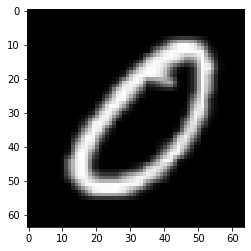

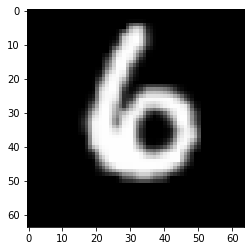

In [15]:
sample = dispenser.get_random_target(2)
plt.imshow(sample[0]/255)
plt.show()
plt.imshow(sample[1]/255)
plt.show()

# GAN Painter

In [16]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

def leaky_relu_batch_norm(x, alpha=0.2):
    return leaky_relu(tf.contrib.layers.batch_norm(x, updates_collections=None), alpha)

def relu_batch_norm(x):
    return tf.nn.relu(tf.contrib.layers.batch_norm(x, updates_collections=None))
  
class DiscriminatorConditionalWM(object):
    def __init__(self, divisor=1):
        """
        make the network smaller by divisor times
        """
        self.x_dim = 64 * 64 * 3
        self.name = 'lsun/dcgan/d_net'
        self.divisor=divisor
        
    def __call__(self, x, conditions, reuse=True):
        with tf.variable_scope(self.name) as vs:
            if reuse:
                vs.reuse_variables()
            bs = tf.shape(x)[0]
            x = tf.reshape(x, [bs, 64, 64, 3])
            conditions = tf.reshape(conditions, [bs, 2])
            conditions = tf.contrib.layers.fully_connected(conditions, 64//self.divisor)
            conditions = tf.reshape(conditions, [bs, 1, 1, 64//self.divisor])
            conv1 = tcl.conv2d(
                x, 64//self.divisor, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu
            )
            conv1 = conv1 + conditions
            conv2 = tcl.conv2d(
                conv1, 128//self.divisor, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu_batch_norm
            )
            conv3 = tcl.conv2d(
                conv2, 256//self.divisor, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu_batch_norm
            )
            conv4 = tcl.conv2d(
                conv3, 512//self.divisor, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu_batch_norm
            )
            conv4 = tcl.flatten(conv4)
            fc = tcl.fully_connected(conv4, 1, activation_fn=tf.identity)
            return fc

    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

class GeneratorConditional(object):
    def __init__(self, divisor=1, add_noise=False):
        self.x_dim = 64 * 64 * 3
        self.divisor=divisor
        self.name = 'lsun/dcgan/g_net'
        self.add_noise = add_noise

    def __call__(self, conditions, is_training):
        with tf.contrib.framework.arg_scope([tcl.batch_norm], 
                                            is_training=is_training):
          with tf.variable_scope(self.name) as vs:
              bs = tf.shape(conditions)[0]
              if self.add_noise:
                conditions = tf.concat([conditions, tf.random.uniform([bs, 10])], axis=1)
              fc = tcl.fully_connected(conditions, 4 * 4 * 1024//self.divisor, activation_fn=tf.identity)
              conv1 = tf.reshape(fc, tf.stack([bs, 4, 4, 1024//self.divisor]))
              conv1 = relu_batch_norm(conv1)
              conv2 = tcl.conv2d_transpose(
                  conv1, 512//self.divisor, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=relu_batch_norm
              )
              conv3 = tcl.conv2d_transpose(
                  conv2, 256//self.divisor, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=relu_batch_norm
              )
              conv4 = tcl.conv2d_transpose(
                  conv3, 128//self.divisor, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=relu_batch_norm
              )
              conv5 = tcl.conv2d_transpose(
                  conv4, 3, [4, 4], [2, 2],
                  weights_initializer=tf.random_normal_initializer(stddev=0.02),
                  activation_fn=tf.sigmoid)
              return conv5

    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]
      
class ConvGAN(object):
  def __init__(self, learning_rate=0.0001, is_training=True, reuse=False, gpu_mode=True, data_glob='data/episodes_*.npz', divisor=1, add_noise=False, graph=None):
    self.learning_rate = learning_rate
    self.is_training = is_training
    self.reuse = reuse
    self.g_net = GeneratorConditional(divisor=divisor, add_noise=add_noise)
    self.d_net = DiscriminatorConditionalWM(divisor=divisor)
    
    if self.is_training:
      self.episode_files = tf.gfile.Glob(data_glob)
      np.random.shuffle(self.episode_files)
      self.ep_file_ctr = 0
      self.current_file_idx = 0
      loaded = np.load(self.episode_files[0])
      self.loaded_strokes = loaded['strokes']
      self.loaded_actions = loaded['actions']
      self.len_loaded = len(self.loaded_strokes)
    
    if not gpu_mode:
      with tf.device('/cpu:0'):
        tf.logging.info('conv_gan using cpu.')
        self._build_training_or_generator_graph(graph)
    else:
      tf.logging.info('conv_gan using gpu.')
      self._build_training_or_generator_graph(graph)
    self._init_session()
   
  def _build_training_or_generator_graph(self, graph):
    if self.is_training:
      self._build_graph(graph)
    else:
      self._build_generator_graph(graph)
  
  def _build_graph(self, graph):
    if graph is None:
      self.g = tf.Graph()
    else:
      self.g = graph
    with self.g.as_default(), tf.variable_scope('conv_gan', reuse=self.reuse):

      self.x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])
      self.actions = tf.placeholder(tf.float32, shape=[None, 2])
      
      self.y = self.g_net(self.actions, is_training=self.is_training)
      
      real_score = tf.reduce_mean(self.d_net(self.x, self.actions, reuse=False))
      generated_score = tf.reduce_mean(self.d_net(self.y, self.actions))
      
      real_score_summ = tf.summary.scalar('real_score', real_score)
      g_loss_summ = tf.summary.scalar('generated_score/g_loss', generated_score)
      
      reconstruction_loss = tf.reduce_mean(tf.square(self.y-self.x))
      recon_loss_summ = tf.summary.scalar('recon_loss', reconstruction_loss)
      
      # actual reconstruction loss used for training
      self.uneven_multiplier = tf.placeholder_with_default(1.0, [])
      u_m_summ = tf.summary.scalar('uneven_multiplier', self.uneven_multiplier)
      mask = tf.reduce_mean(
        self.x,
        reduction_indices = [3]
      )
      stroke_whitespace = tf.equal(mask, 1.0)
      mask = tf.where(stroke_whitespace, tf.ones(tf.shape(mask)), self.uneven_multiplier*tf.ones(tf.shape(mask)))
      mask = tf.reshape(mask, [-1, 64, 64, 1])
      mask = tf.tile(mask, [1, 1, 1, 3])
      tf.summary.image('mask', mask, max_outputs=3)
      print(mask.get_shape())
      self.r_loss = 10*tf.reduce_mean((tf.square(self.x - self.y))*mask)
      actual_recon_loss_summ = tf.summary.scalar('recon_loss_actual', self.r_loss)
      # /actual reconstruction loss used for training
      
      self.g_loss = generated_score + self.r_loss
      self.d_loss = real_score - generated_score
      
      epsilon = tf.random_uniform([], 0.0, 1.0)
      x_hat = epsilon * self.x + (1 - epsilon) * self.y
      d_hat = self.d_net(x_hat, self.actions)
      
      ddx = tf.gradients(d_hat, x_hat)[0]
      print(ddx.get_shape().as_list())

      ddx = tf.sqrt(tf.reduce_sum(tf.square(ddx), axis=(1, 2, 3)))
      ddx = tf.reduce_mean(tf.square(ddx - 1.0) * 10.0)
      
      self.d_loss = self.d_loss + ddx
      
      gradient_penalty_summ = tf.summary.scalar('gradient_penalty', ddx)
      d_loss_summ = tf.summary.scalar('actual_loss', self.d_loss)
      
      # train ops
      if self.is_training:
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.inc_global_step = tf.assign(self.global_step, self.global_step+1)

        self.d_adam, self.g_adam = None, None
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            self.d_adam = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)\
                .minimize(self.d_loss, var_list=self.d_net.vars)
            self.g_adam = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)\
                .minimize(self.g_loss, var_list=self.g_net.vars)

      # initialize vars
      self.init = tf.global_variables_initializer()
      
      #summary ops
      tf.summary.image('inp_img', self.x, max_outputs=3)
      tf.summary.image('output_img', self.y, max_outputs=3)
      self.summary_op = tf.summary.merge_all()
      
  def _build_generator_graph(self, graph):
    if graph is None:
      self.g = tf.Graph()
    else:
      self.g = graph
      
    with self.g.as_default(), tf.variable_scope('conv_gan', reuse=self.reuse):
      self.actions = tf.placeholder(tf.float32, shape=[None, 2])
      self.y = self.g_net(self.actions, is_training=self.is_training)
      self.init = tf.global_variables_initializer()
  
  def generate_stroke_graph(self, actions):
    with tf.variable_scope('conv_gan', reuse=True):
      with self.g.as_default():
        return self.g_net(actions, is_training=False)
      
  def get_random_batch(self, batch_size):
    while self.len_loaded - self.current_file_idx < batch_size:
      self.ep_file_ctr = (self.ep_file_ctr + 1) % len(self.episode_files)
      self.current_file_idx = 0
      print('loading new file', self.episode_files[self.ep_file_ctr])
      loaded = np.load(self.episode_files[self.ep_file_ctr])
      self.loaded_strokes = loaded['strokes']
      self.loaded_actions = loaded['actions']
      self.len_loaded = len(self.loaded_strokes)
      rand_idx = np.random.permutation(self.len_loaded)
      self.loaded_strokes = self.loaded_strokes[rand_idx]
      self.loaded_actions = self.loaded_actions[rand_idx]
    
    strokes = self.loaded_strokes[self.current_file_idx:self.current_file_idx+batch_size]
    strokes = strokes.astype(np.float)/255.0
    actions = self.loaded_actions[self.current_file_idx:self.current_file_idx+batch_size]
    
    self.current_file_idx += batch_size
    
    return strokes, actions
      
  def train(self, batch_size=64, num_batches=1000000):
    train_writer = tf.summary.FileWriter('logdir', self.g)
    start_time = time.time()
    uneven_multiplier = 10.
    for t in range(num_batches):
        d_iters = 5

        for _ in range(0, d_iters):
            strokes, actions = self.get_random_batch(batch_size)
            _, summ = self.sess.run((self.d_adam, self.summary_op), 
                                    feed_dict={self.x: strokes, self.actions: actions})

        strokes, actions = self.get_random_batch(batch_size)
        _, summ, _, step = self.sess.run((self.g_adam, self.summary_op, self.inc_global_step, self.global_step), 
                                      feed_dict={self.x: strokes, 
                                                 self.actions: actions, 
                                                 self.uneven_multiplier: uneven_multiplier})
        train_writer.add_summary(summ, step)
        
        if step > 295044:
          uneven_multiplier = 1.

        if step % 20 == 0:
            strokes, actions = self.get_random_batch(batch_size)
            d_loss = self.sess.run(
                self.d_loss, feed_dict={self.x: strokes, self.actions: actions}
            )
            g_loss = self.sess.run(
                self.g_loss, feed_dict={self.x: strokes, self.actions: actions}
            )
            print('Iter [%8d] Time [%5.4f] d_loss [%.4f] g_loss [%.4f]' %
                    (step, time.time() - start_time, d_loss, g_loss))
            
        if step % 2000 == 0:
            self.save_model()

  def _init_session(self):
    """Launch TensorFlow session and initialize variables"""
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
  def close_sess(self):
    """ Close TensorFlow session """
    self.sess.close()
  def save_model(self, model_save_path='tf_gan3'):
    sess = self.sess
    step = sess.run(self.global_step)
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    checkpoint_path = os.path.join(model_save_path, 'gan')
    tf.logging.info('saving model %s.', checkpoint_path)
    saver.save(sess, checkpoint_path, step) # just keep one
  def load_checkpoint(self, checkpoint_path='tf_gan3', actual_path=None):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    if actual_path is None:
      actual_path = ckpt.model_checkpoint_path
    print('loading model', actual_path)
    tf.logging.info('Loading model %s.', actual_path)
    saver.restore(sess, actual_path)

# Adversarial Training graph

In [17]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(tf.minimum(0.0, alpha * x), x)

def leaky_relu_batch_norm(x, alpha=0.2):
    return leaky_relu(tf.contrib.layers.batch_norm(x, updates_collections=None), alpha)

def relu_batch_norm(x):
    return tf.nn.relu(tf.contrib.layers.batch_norm(x, updates_collections=None))

def res_block(x, channel, size, name):
    with tf.variable_scope(name):
        enc_x = tf.contrib.layers.conv2d(
                x, channel, size,
                padding='same',
                activation_fn=tf.nn.relu)

        res = tf.contrib.layers.conv2d(
                enc_x, channel, size,
                padding='same',
                activation_fn=None) + x
    return res

class ActionGenerator2(object):
    def __init__(self):
        self.name = 'action_generator2'
        self.cell = None
        
    def create_cell(self):
        with tf.variable_scope(self.name) as vs:
            self.cell = tf.nn.rnn_cell.LSTMCell(256)
            return self.cell

    def __call__(self, prev_cell_state, prev_hidden_state, prev_actions, current_canvas, target_image, reuse=True):
        if self.cell is None:
            self.create_cell()
            
        with tf.variable_scope(self.name) as vs:
            if reuse:
                vs.reuse_variables()
            bs = tf.shape(prev_hidden_state)[0]
            
            prev_actions = tf.contrib.layers.fully_connected(prev_actions, 32)
            concat_actions_world = tf.reshape(prev_actions, [bs, 1, 1, 32])
            
            current_canvas = tf.reshape(current_canvas, [bs, 64, 64, 3])
            target_image = tf.reshape(target_image, [bs, 64, 64, 3])
            concat_canvas = tf.concat([current_canvas, target_image], axis=3)  # Does this make sense? idk
            
            concat_canvas = tf.contrib.layers.conv2d(
              concat_canvas, 32, 5, scope="x_c_enc"
            )
            
            conditioned_canvas = concat_canvas + concat_actions_world
            
            for idx in range(int(3)):
                conditioned_canvas = tf.contrib.layers.conv2d(
                        conditioned_canvas, 32, 4, stride=(2, 2),
                        padding='valid',
                        activation_fn=tf.nn.relu,
                        scope="add_enc_{}".format(idx))
            for idx in range(8):
                conditioned_canvas = res_block(
                        conditioned_canvas, 32, 3,
                        name="encoder_res_{}".format(idx))
                
            conditioned_canvas = tf.contrib.layers.flatten(conditioned_canvas)
            
            lstm_in = tf.contrib.layers.fully_connected(conditioned_canvas, 256)
            
            lstm_out, lstm_state = self.cell(lstm_in, tf.nn.rnn_cell.LSTMStateTuple(prev_cell_state, prev_hidden_state))
            
            fc = tf.contrib.layers.fully_connected(lstm_out, 2, activation_fn=tf.sigmoid)
            #fc = tf.concat([tf.zeros([bs, 1]), fc[:, 1:]], axis=1)
            return fc, lstm_state

    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

class DiscriminatorConditional(object):
    def __init__(self):
        self.x_dim = 64 * 64 * 3
        self.name = 'lsun/dcgan/d_net'

    def __call__(self, x, target, reuse=True):
        with tf.variable_scope(self.name) as vs:
            if reuse:
                vs.reuse_variables()
            bs = tf.shape(x)[0]
            x = tf.reshape(x, [bs, 64, 64, 3])
            target = tf.reshape(target, [bs, 64, 64, 3])
            x = tf.concat([x, target], axis=3)
            conv1 = tcl.conv2d(
                x, 64, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu
            )
            conv2 = tcl.conv2d(
                conv1, 128, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu_batch_norm
            )
            conv3 = tcl.conv2d(
                conv2, 256, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu_batch_norm
            )
            conv4 = tcl.conv2d(
                conv3, 512, [4, 4], [2, 2],
                weights_initializer=tf.random_normal_initializer(stddev=0.02),
                activation_fn=leaky_relu_batch_norm
            )
            conv4 = tcl.flatten(conv4)
            fc = tcl.fully_connected(conv4, 1, activation_fn=tf.identity)
            return fc

    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

In [19]:
class AdversarialGraph(object):
  def __init__(self, max_seq_len=8, painter_type="VAE", gpu_mode=True, graph=None):
    self.painter_type=painter_type
    self.action_generator = ActionGenerator2()
    self.d_net = DiscriminatorConditional()
    self.data_dispenser = MnistDispenser()
    self.max_seq_len = max_seq_len
    
    self.gpu_mode = gpu_mode
    if not gpu_mode:
      with tf.device('/cpu:0'):
        tf.logging.info('Model using cpu.')
        self._build_graph(graph)
    else:
      tf.logging.info('Model using gpu.')
      self._build_graph(graph)
    self._init_session()
  
  def get_random_batch(self, batch_size, train=True):
    random_targets = self.data_dispenser.get_random_target(batch_size, train=train)
    random_targets = 1 - random_targets.astype(np.float)/255.
    return random_targets
    
    # sanity check
    #self.target_np = self.mnist_env.real_data[1].reshape([1, 64, 64, 1])
    #self.target_np_batch = np.tile(self.target_np, [batch_size,1,1,3]).astype(np.float)/255.0
    #return self.target_np_batch
  
  def _build_graph(self, graph):
    if graph is None:
      self.g = tf.Graph()
    else:
      self.g = graph
    
    # Set up graphs of GAN
    if self.painter_type == "VAE":
      self.painter = ConvVAE(z_size=64, batch_size=100, 
                         learning_rate=1e-4, kl_tolerance=0.5, 
                         gpu_mode=self.gpu_mode, is_training=False, 
                         reuse=False, graph=self.g)
    else:
      self.painter = ConvGAN(learning_rate=1e-4,
              is_training=False,
              reuse=False,
              gpu_mode=self.gpu_mode,
              divisor=4,
              add_noise=False,
              graph=self.g)
    self.painter.close_sess()
    with self.g.as_default():
      print(tf.global_variables())
    
    with self.g.as_default():
      self.target_image = tf.placeholder(dtype=tf.float32, shape=[None, 64, 64, 3])
      
      batch_size = tf.shape(self.target_image)[0]
            
      # Prepare loop vars for rnn loop
      canvas_state = tf.ones(shape=[batch_size, 64, 64, 3], dtype=tf.float32)
      actions = tf.zeros(shape=[batch_size, 2], dtype=tf.float32)
      action_cell_state, action_hidden_state = self.action_generator.create_cell().zero_state(batch_size=batch_size, dtype=tf.float32)
      i = tf.constant(0)
      initial_ta = tf.TensorArray(dtype=tf.float32, size=self.max_seq_len)
      initial_canvas_ta = tf.TensorArray(dtype=tf.float32, size=self.max_seq_len)
      loop_vars = (
          canvas_state, actions, action_cell_state, action_hidden_state, 
          initial_ta, initial_canvas_ta, i)
      
      # Just make the graph variables so we can use it in the loop. TODO: Can't I create this in the loop itself?
      self.action_generator(action_cell_state, action_hidden_state, actions, canvas_state, canvas_state, reuse=False)
      
      # condition for continuation
      def cond(cs, ac, acs, ahs, i_ta, c_ta, i):
        return tf.less(i, self.max_seq_len)
      
      # run one state of rnn cell
      def body(cs, ac, acs, ahs, i_ta, c_ta, i):
        i = tf.add(i, 1)
        
        prev_ac = ac
        ac, (acs, ahs) = self.action_generator(acs, ahs, ac, cs, self.target_image)
        i_ta = i_ta.write(i-1, ac)

        def use_whole_action():
          return ac
        
        ac = use_whole_action()
        
        
        decoded_stroke = self.painter.generate_stroke_graph(ac)

#         darkness_mask = tf.reduce_mean(decoded_stroke, axis=3)
#         darkness_mask = 1 - tf.reshape(darkness_mask, [batch_size, 64, 64, 1])
#         darkness_mask = darkness_mask / tf.reduce_max(darkness_mask)
        
        # TODO ISSUES HERE: rewrite logic for our setup with no MyPaint and Color...
#         color_action = ac[:, 6:9]
#         color_action = tf.reshape(color_action, [batch_size, 1, 1, 3])
#         color_action = tf.tile(color_action, [1, 64, 64, 1])
#         stroke_whitespace = tf.equal(decoded_stroke, 1.)

#         maxed_stroke = tf.where(stroke_whitespace, decoded_stroke, color_action)
        
#         cs = cs + decoded_stroke #(darkness_mask)*maxed_stroke + (1-darkness_mask)*cs
        
        mask_darker = tf.greater(decoded_stroke, cs)
        
        cs = tf.where(mask_darker, cs, decoded_stroke)

        c_ta = c_ta.write(i-1, cs)
        
        return (cs, ac, acs, ahs, i_ta, c_ta, i)
      
      final_canvas_state, ac, _, _, final_ta, final_canvas_ta, _ = tf.while_loop(cond, body, loop_vars, swap_memory=True)
      self.final_canvas_state = final_canvas_state
      self.last_actions = final_ta.stack()
      self.intermediate_canvases = final_canvas_ta.stack()
      
      real_score = tf.reduce_mean(self.d_net(self.target_image, self.target_image, reuse=False))
      generated_score = tf.reduce_mean(self.d_net(final_canvas_state, self.target_image))
      
      real_score_summ = tf.summary.scalar('real score', real_score)
      g_loss_summ = tf.summary.scalar('generated score/g_loss', generated_score)
      
      self.g_loss = generated_score
      reconstruction_loss = 10*tf.reduce_mean(tf.square(final_canvas_state-self.target_image))
      recon_loss_summ = tf.summary.scalar('recon_loss', reconstruction_loss)
      self.g_loss = self.g_loss + reconstruction_loss
     
      self.d_loss = real_score - generated_score
      
      real_min_gen_summ = tf.summary.scalar('real - generated', self.d_loss)
      
      epsilon = tf.random_uniform([], 0.0, 1.0)
      x_hat = epsilon * self.target_image + (1 - epsilon) * final_canvas_state
      d_hat = self.d_net(x_hat, self.target_image)
      
      # TODO: This might be wrong. might need to calc gradients wrt xhat concated with target
      ddx = tf.gradients(d_hat, x_hat)[0]
      print(ddx.get_shape().as_list())
      #ddx = tf.sqrt(tf.reduce_sum(tf.square(ddx), axis=1))
      ddx = tf.sqrt(tf.reduce_sum(tf.square(ddx), axis=(1, 2, 3)))
      ddx = tf.reduce_mean(tf.square(ddx - 1.0) * 10.0)
      
      self.d_loss = self.d_loss + ddx
      
      gradient_penalty_summ = tf.summary.scalar('gradient penalty', ddx)
      d_loss_summ = tf.summary.scalar('actual loss', self.d_loss)
        
      self.d_adam, self.g_adam = None, None
      with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
          self.d_adam = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)\
              .minimize(self.d_loss, var_list=self.d_net.vars)
          self.g_adam = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)\
              .minimize(self.g_loss, var_list=self.action_generator.vars)
        

      # initialize vars
      self.init = tf.global_variables_initializer()
      
      #summary ops
      real_im_summ = tf.summary.image('real_images', self.target_image, max_outputs=3)
      gen_im_summ = tf.summary.image('generated_images', final_canvas_state, max_outputs=3)
      self.summary_op = tf.summary.merge([real_im_summ, gen_im_summ, d_loss_summ, gradient_penalty_summ, 
                                          real_min_gen_summ, g_loss_summ, real_score_summ,
                                          recon_loss_summ,
                                         ])
      
  def train(self, batch_size=64, num_batches=1000000, last_actions_arr=[0, 1, 2], start_batch=0):
    train_writer = tf.summary.FileWriter('logdir', self.g)
    start_time = time.time()
    for t in range(start_batch, num_batches):
        d_iters = 5

        for _ in range(0, d_iters):
            _, summ = self.sess.run((self.d_adam, self.summary_op), feed_dict={self.target_image: self.get_random_batch(batch_size)})

        rand_batch = self.get_random_batch(batch_size)
        _, last_actions, fcstate, summ = self.sess.run((self.g_adam, self.last_actions, self.final_canvas_state, self.summary_op), feed_dict={self.target_image: rand_batch})
        last_actions_arr[0] = last_actions
        last_actions_arr[1] = fcstate
        last_actions_arr[2] = rand_batch
        train_writer.add_summary(summ, t)

        if t % 100 == 0:

            d_loss = self.sess.run(
                self.d_loss, feed_dict={self.target_image: self.get_random_batch(batch_size)}
            )
            g_loss = self.sess.run(
                self.g_loss, feed_dict={self.target_image: self.get_random_batch(batch_size)}
            )
            print('Iter [%8d] Time [%5.4f] d_loss [%.4f] g_loss [%.4f]' %
                    (t, time.time() - start_time, d_loss, g_loss))
            
        if t % 100 == 0:
            self.save_model('adversarial_global_vars_celeba')

  def _init_session(self):
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
  def close_sess(self):
    self.sess.close()
    
  def load_painter_checkpoint(self, checkpoint_path='tf_conv_vae', actual_path=None):
    sess = self.sess
    with self.g.as_default():
      if self.painter_type == "VAE":
        pth = 'conv_vae'
      elif self.painter_type == "GAN":
        pth = 'conv_gan'
      saver = tf.train.Saver(tf.global_variables(pth))
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    if actual_path is None:
      actual_path = ckpt.model_checkpoint_path
    print('loading model', actual_path)
    tf.logging.info('Loading model %s.', actual_path)
    saver.restore(sess, actual_path)

  def save_model(self, model_save_path='adversarial_global_vars_celeba'):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    checkpoint_path = os.path.join(model_save_path, 'graph')
    tf.logging.info('saving model %s.', checkpoint_path)
    saver.save(sess, checkpoint_path, 0) # just keep one
  def load_checkpoint(self, checkpoint_path='adversarial_global_vars_celeba'):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    print('loading model', ckpt.model_checkpoint_path)
    tf.logging.info('Loading model %s.', ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)


# Actual training

In [20]:
# rm data/celeba/celeba_dict.pkl # TODO: for some reasons pickle doesn't work...

In [21]:
# Initialize the graph. This step will also preprocess all CelebA images to 64x64 the first time you run it.
lol = AdversarialGraph(max_seq_len=20, painter_type='GAN')

INFO:tensorflow:Model using gpu.
INFO:tensorflow:conv_gan using gpu.
Instructions for updating:
Colocations handled automatically by placer.
[<tf.Variable 'conv_gan/lsun/dcgan/g_net/fully_connected/weights:0' shape=(2, 4096) dtype=float32_ref>, <tf.Variable 'conv_gan/lsun/dcgan/g_net/fully_connected/biases:0' shape=(4096,) dtype=float32_ref>, <tf.Variable 'conv_gan/lsun/dcgan/g_net/BatchNorm/beta:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'conv_gan/lsun/dcgan/g_net/BatchNorm/moving_mean:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'conv_gan/lsun/dcgan/g_net/BatchNorm/moving_variance:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'conv_gan/lsun/dcgan/g_net/Conv2d_transpose/weights:0' shape=(4, 4, 128, 256) dtype=float32_ref>, <tf.Variable 'conv_gan/lsun/dcgan/g_net/Conv2d_transpose/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'conv_gan/lsun/dcgan/g_net/Conv2d_transpose/BatchNorm/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'conv_gan/lsun/dcgan/g_net/Conv2

In [22]:
# Load GAN painter checkpoint
lol.load_painter_checkpoint('tf_gan3')

loading model tf_gan3/gan-12000
INFO:tensorflow:Loading model tf_gan3/gan-12000.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from tf_gan3/gan-12000


In [45]:
# Resume training from checkpoint
# lol.load_checkpoint('adversarial_global_vars_celeba')

In [ ]:
last_arr = [None, None, None]
lol.train(last_actions_arr = last_arr, start_batch=0)

In [25]:
lol.save_model()

INFO:tensorflow:saving model adversarial_global_vars_celeba/graph.


# evaluate model

In [26]:
def plot_images(images):
#   h=64#args.screen_size
  fig=plt.figure(figsize=(16, 16))
  columns = len(images)
  rows = 1

  for i, img in enumerate(images):
    img = img[:, :, :3]
    #print(img.shape)
    fig.add_subplot(rows, columns, i+1)
    plt.grid(False)
    plt.imshow(img)
  plt.show()


In [27]:
# _realEnv = ColorEnv(args, paint_mode=PaintMode.JUMP_STROKES)

# def run_actions_on_real_env(realEnv, actions_array):
#   images = []
#   realEnv.reset()
#   for ac in actions_array:
#     print(ac)
#     realEnv.draw(ac.astype(np.float64))
#     images.append(realEnv.image)
#   plot_images(images)
# run_actions_on_real_env(_realEnv, last_arr[0][:, 41, :])
# plot_images(last_arr[1][40:48])
# plot_images(last_arr[2][40:48])

# Generate animations with test data

In [66]:
_ran_batch = lol.get_random_batch(5, train=True)
_last_actions, _fcstate, _int_canvases = lol.sess.run((lol.last_actions, lol.final_canvas_state, lol.intermediate_canvases), feed_dict={lol.target_image: _ran_batch})


In [75]:
_fcstate.shape

(5, 64, 64, 3)

In [68]:
_last_actions.shape

(20, 5, 2)

In [69]:
_int_canvases.shape

(20, 5, 64, 64, 3)

In [70]:
print(_int_canvases[0,3,:,:].min())
print(_int_canvases[0,3,:,:].max())

0.005072564
1.0


In [71]:
print(_fcstate[0,0,:,:].min())
print(_fcstate[0,0,:,:].max())

0.22680068
1.0


In [72]:
_fcstate.shape

(5, 64, 64, 3)

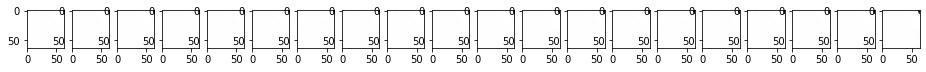

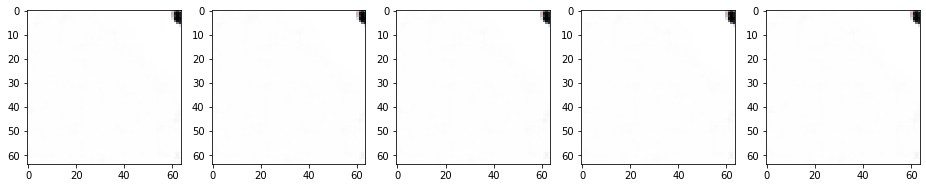

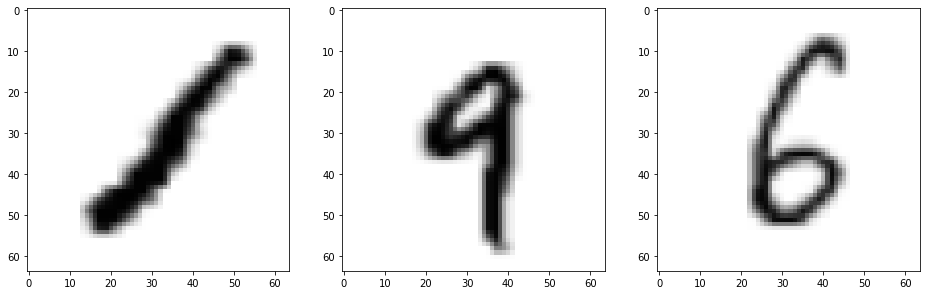

In [73]:
# def run_actions_on_real_env(realEnv, actions_array):
#   images = []
#   realEnv.reset()
#   for ac in actions_array:
#     realEnv.draw(ac.astype(np.float64))
#     images.append(realEnv.image)
#   return images
# _imgs = run_actions_on_real_env(_realEnv, _last_actions[:, 9, :])
# plot_images(_imgs[80:])
plot_images(_int_canvases[:, 3, :, :])
plot_images(_fcstate)
plot_images(_ran_batch[:3])

In [74]:
import imageio

_final_to_plot = []
for _target in range(20):
  run_actions_on_real_env(_realEnv, _last_actions[:, _target, :])
  print(len(_realEnv.intermediate_images))
  _realEnv.intermediate_images = _realEnv.intermediate_images[0::30]

  _inter_images = np.stack(_realEnv.intermediate_images)[:, :, :, :3].astype(np.uint8)#.astype(np.float)/255.
  _target_images = (np.tile(_ran_batch[_target].reshape(1, 64, 64, 3), [len(_realEnv.intermediate_images), 1, 1, 1])*255).astype(np.uint8)

  _plot = np.concatenate([_target_images, _inter_images], axis=2)
  _final_to_plot.append(_plot)

_rows = 5
_cols = 4
_rows_to_stack = []
for i in range(_rows):
  _rows_to_stack.append(np.concatenate(_final_to_plot[i*_cols:(i+1)*_cols], axis=2))


clip = mpy.ImageSequenceClip([x for x in (np.concatenate(_rows_to_stack, axis=1))], fps=14)
clip.write_videofile("hello.mp4")
display(mpy.ipython_display('hello.mp4', height=400))

NameError: name 'run_actions_on_real_env' is not defined

In [36]:

_stacked_plots = []
for _target in range(5, 20):
  run_actions_on_real_env(_realEnv, _last_actions[:, _target, :])
  print(len(_realEnv.intermediate_images))
  _realEnv.intermediate_images = _realEnv.intermediate_images[0::37]

  _inter_images = np.stack(_realEnv.intermediate_images)[:, :, :, :3].astype(np.float)/255.
  _intermediate_canvases_to_plot = np.repeat(_int_canvases[:, _target, :, :, :], 53, axis=0)[0::19]
  _target_images = np.tile(_ran_batch[_target].reshape(1, 64, 64, 3), [len(_realEnv.intermediate_images), 1, 1, 1])

  print(len(_realEnv.intermediate_images))
  print(_target_images.shape, _intermediate_canvases_to_plot.shape, _inter_images.shape)

  _plot = np.concatenate([_target_images, _intermediate_canvases_to_plot, _inter_images], axis=2)
  _stacked_plots.append(_plot)

  
clip = mpy.ImageSequenceClip([x for x in (np.concatenate(_stacked_plots)*255).astype(np.uint8)], fps=14)
clip.write_videofile("hello2.mp4")
display(mpy.ipython_display('hello2.mp4', height=200))

NameError: name '_realEnv' is not defined